In [1]:
# =========================
# Libraries
# =========================

import numpy as np
import pandas as pd
import emcee
from multiprocessing import pool
import multiprocessing as mp
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

In [2]:
# =========================
# Loading CC data
# =========================

# Path
cc_dat_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/CC/CC_Hz_data.txt"

# DataFrame
df_cc = pd.read_csv(cc_dat_path, sep=r"\s+")

# Main columns
z_cc   = df_cc["z_cc"].to_numpy(float)
H_obs  = df_cc["H_cc"].to_numpy(float)
H_err   = df_cc["H_cc_err"].to_numpy(float)

In [3]:
# ===================
# Fiducial
# ===================

# Uniform priors
H0_min, H0_max = 50., 90.
Om0_min, Om0_max = 0.1, 0.6
w_min, w_max = -3.0, 1.0

# Cosmological parameter
Or0 = 7.88e-5

In [4]:
# =========================
# Hubble functions
# =========================

# Normalized Hubble parameter
def E_wCDM(z, Om0, w):

    # Matter density parameter
    Om = Om0 * (1 + z)**3

    # Radiation density parameter
    Or = Or0 * (1 + z)**4

    # Dark energy density parameter
    Ode0 = 1 - Om0 - Or0
    power = 3*(1 + w)
    Ode = Ode0 * (1 + z)**power
    
    return np.sqrt(Om + Or + Ode)

# Hubble parameter
def H_wCDM(z, H0, Om0, w):
    return H0 * E_wCDM(z, Om0, w)


# ==========================
# Sanity test
# ==========================

print("H_wCDM(z_cc) =", H_wCDM(z_cc, 70, 0.3, -1))

H_wCDM(z_cc) = [ 72.32519073  73.03322223  74.1314077   76.05727142  76.41650152
  77.22840645  77.26949293  80.26045951  80.70603325  84.04613925
  85.41639663  86.39894212  86.41896391  87.6479917   88.93827653
  90.00503138  90.44605904  90.53673656  96.82219995 101.99455245
 106.35561345 106.35561345 108.34165726 109.57512132 114.56145767
 114.90041394 116.26425003 125.94082281 142.8571158  146.03393133
 151.12077405 156.63961932 165.07883266 184.45352498 204.39287936]


In [5]:
# =========================================
# CC Likelihood
# =========================================

# Log-priors
def lnprior_cc(theta_cc):

    # Params vector
    H0, Om0, w = theta_cc

    # Flat priors
    if not (H0_min <= H0 <= H0_max): return -np.inf
    if not (Om0_min <= Om0 <= Om0_max): return -np.inf
    if not (w_min <= w <= w_max): return -np.inf
    
    return 0.0


# Log-likelihood
def lnlike_cc(theta_cc, z_cc, H_obs, H_err):
    H0, Om0, w = theta_cc

    # Theoretical Hubble parameter
    H_model = H_wCDM(z_cc, H0, Om0, w)

    # Chi-squared
    chi2_cc = np.sum(((H_obs - H_model) / H_err)**2) 
    return -0.5 * chi2_cc


# Log-posterior
def lnprob_cc(theta_cc, z_cc, H_obs, H_err):

    # Log-prior
    lp = lnprior_cc(theta_cc)
    if not np.isfinite(lp):
        return -np.inf
    
    # Log-likelihood
    ll = lnlike_cc(theta_cc, z_cc, H_obs, H_err)
    return lp + ll


# =================
# Quick test
# =================

theta_cc_test = [70, 0.3, -1.0]
print("wCDM_CC log-posterior =", lnprob_cc(theta_cc_test, z_cc, H_obs, H_err))

wCDM_CC log-posterior = -7.567754214643069


In [6]:
# =========================
# MCMC configuration
# =========================

# Dimensions and sampling settings
ndim, nwalkers, nsteps, nburn = 3, 40, 53500, 3500
rng = np.random.default_rng(42)

# Initial walker positions drawn from priors
p0 = np.zeros((nwalkers, ndim))
p0[:,0] = rng.uniform(H0_min, H0_max, size=nwalkers)       # Uniform H0
p0[:,1] = rng.uniform(Om0_min, Om0_max, size=nwalkers)     # Uniform Omega_m0
p0[:,2] = rng.uniform(w_min, w_max, size=nwalkers)         # Uniform w


# Parallel chain generation (LESS efficient for wCDM_CC)
# with mp.Pool(processes=nwalkers) as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_cc, args=(z_cc, H_obs, H_err), pool=pool)
#     sampler.run_mcmc(p0, nsteps, progress=True)

# Single-threaded chain generation (MORE efficient for wCDM_CC)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_cc, args=(z_cc, H_obs, H_err))
sampler.run_mcmc(p0, nsteps, progress=True)


# Full chain: shape (nsteps, nwalkers, ndim)
chain = sampler.get_chain()
# np.save("chain_wCDM_cc.npy", chain)

# Flattened chain after burn-in: shape (N_total, ndim)
flat_samples = sampler.get_chain(discard=nburn, flat=True)
np.save("flat_samples_wCDM_cc.npy", flat_samples)

100%|██████████| 53500/53500 [00:36<00:00, 1473.36it/s]


Removed no burn in


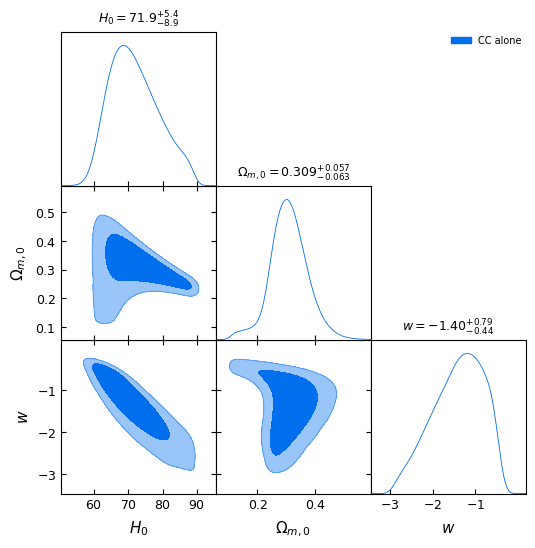

In [7]:
# =========================
# Corner plot using GetDist
# =========================

# Parameter names and LaTeX labels
param_names  = ["H0", "Omega_m0", "w"]
param_labels = [r"H_0", r"\Omega_{m,0}", r"w"]


# Create GetDist samples object
samples = MCSamples(
    samples=flat_samples,
    names=param_names,
    labels=param_labels
)

# Smoothing and binning settings
samples.updateSettings({
    "smooth_scale_1D": 0.25,
    "smooth_scale_2D": 0.25,
    "fine_bins": 1024,
    "fine_bins_2D": 1024

})


# Parameter ranges (optional)
# samples.setRanges({
#     "param p1": (p1_min, p1_max),
#     "param p2": (p2_min, p2_max),
#     "param p3": (p3_min, p3_max)
# })


# Initialize GetDist subplot plotter
g = plots.get_subplot_plotter()

# Plot styling settings
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 10
g.settings.linewidth_contour = 1.2
g.settings.num_plot_contours = 2
g.settings.axis_marker_lw = 1.0
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.3


# Triangle (corner) plot
g.triangle_plot(
    samples,
    filled=True,
    legend_labels=["CC alone"],
    #contour_colors=["#"],
    title_limit=1
)

# Save figure
plt.savefig("triangle_wCDM_cc.png", dpi=300, bbox_inches="tight")
plt.show()